In [1]:
# Simple CNN model for CIFAR-10
import numpy
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


K.image_data_format()

'channels_last'

We load in a GPU as it's very much needed and   
find it's location

In [2]:
# Standard script to load GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUS Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUS Available:  1
Found GPU at: /device:GPU:0


We load, split, an then preprocess the train and test datasets

In [3]:
#fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# We check the shapes of our datasets to get proper dimensions
print(X_train.shape)
print(y_test.shape[1])

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
10


We update the model to have more convolutional layers that become more rebust and alternate Maxpooling to identify key features and Dropout to add random noise.

In [5]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


In [7]:
# Compile model
with tf.device('/gpu:0'):
  epochs = 25
  lrate = 0.01
  decay = lrate/epochs
  sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  print(model.summary())
  # Fit the model
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
  # Final evaluation of the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

Here we then present individual images to run across our model to test it's accuracy on a case by case basis

  Predicted index:  5


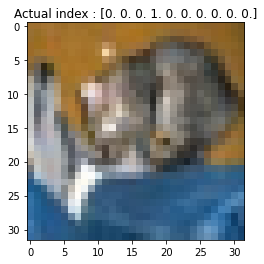

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(X_test[0,:,:],cmap='gray')
plt.title('Actual index : {}'.format(y_test[0]))
print("  Predicted index: ",np.argmax(model.predict(X_test[0,:,:].reshape(-1,32,32,3))))

  Predicted index:  8


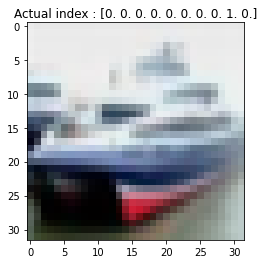

In [9]:
plt.imshow(X_test[1,:,:],cmap='gray')
plt.title('Actual index : {}'.format(y_test[1]))
print("  Predicted index: ",np.argmax(model.predict(X_test[1,:,:].reshape(-1,32,32,3))))

  Predicted index:  8


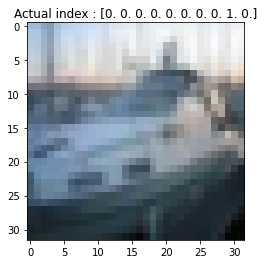

In [10]:
plt.imshow(X_test[2,:,:],cmap='gray')
plt.title('Actual index : {}'.format(y_test[2]))
print("  Predicted index: ",np.argmax(model.predict(X_test[2,:,:].reshape(-1,32,32,3))))

  Predicted index:  0


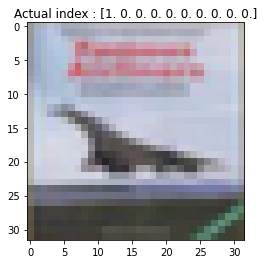

In [14]:
plt.imshow(X_test[3,:,:],cmap='gray')
plt.title('Actual index : {}'.format(y_test[3]))
print("  Predicted index: ",np.argmax(model.predict(X_test[3,:,:].reshape(-1,32,32,3))))

Finally using the history object we plot the pregression of the model over the amount of epochs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


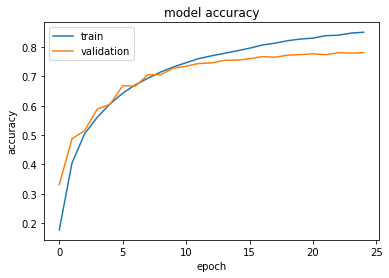

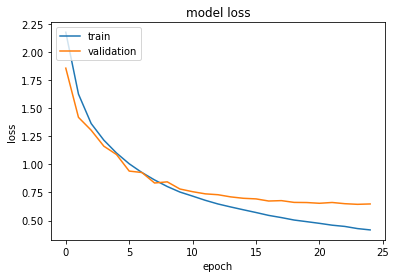

In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()